<a href="https://colab.research.google.com/github/Gemlala/AI-Projekt/blob/woche2/Kreisel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. Sicherstellen, dass wir im richtigen Ordner sind
%cd /content/drive/MyDrive/AI-Projekt

# 2. Status prüfen (du solltest sehen, dass Kreisel.ipynb geändert wurde)
!git status

/content/drive/MyDrive/AI-Projekt
On branch woche2
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	runs/
	ultralytics/
	yolo11n.pt
	yolov8n-obb.pt

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
import os
import glob
from PIL import Image
from tqdm.auto import tqdm # Import für den Fortschrittsbalken

# Pfade
input_tiles = "/content/drive/MyDrive/Colab Notebooks/Bsc/SwissImageTiles_Kreisel_0.1m"
yolo_root = "/content/drive/MyDrive/Colab Notebooks/Bsc/YOLO_Dataset"

os.makedirs(f"{yolo_root}/images", exist_ok=True)
os.makedirs(f"{yolo_root}/labels", exist_ok=True)

tif_files = glob.glob(os.path.join(input_tiles, "*.tif"))

print(f"Starte Label-Generierung für {len(tif_files)} Kreisel-Bilder...")

# Wir packen die Schleife in tqdm()
for tif_path in tqdm(tif_files, desc="Konvertierung & Labeling"):
    file_name = os.path.basename(tif_path)
    base_name = os.path.splitext(file_name)[0]

    # Pfad für das Ziel-Bild prüfen, um Zeit zu sparen (Skip falls existiert)
    target_img_path = os.path.join(yolo_root, "images", f"{base_name}.jpg")

    if not os.path.exists(target_img_path):
        # 1. Bild konvertieren (TIF -> JPG)
        with Image.open(tif_path) as img:
            rgb_img = img.convert('RGB')
            rgb_img.save(target_img_path, quality=95)

    # 2. YOLO Label erstellen
    with open(os.path.join(yolo_root, "labels", f"{base_name}.txt"), "w") as f:
        f.write("0 0.5 0.5 0.8 0.8\n")

print(f"\n✅ Fertig! Datensatz bereit in: {yolo_root}")

In [3]:
%pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
import yaml

data_config = {
    'train': '/content/drive/MyDrive/Colab Notebooks/Bsc/YOLO_Dataset/images',
    'val': '/content/drive/MyDrive/Colab Notebooks/Bsc/YOLO_Dataset/images', # Für den Anfang nutzen wir dieselben Bilder
    'nc': 1,
    'names': ['Kreisel']
}

with open('/content/drive/MyDrive/Colab Notebooks/Bsc/YOLO_Dataset/data.yaml', 'w') as f:
    yaml.dump(data_config, f)

In [5]:
# 1. Lade ein vortrainiertes Nano-Modell (schnell und effizient)
model = YOLO("yolo11n.pt")

# 2. Starte das Training
results = model.train(
    data='/content/drive/MyDrive/Colab Notebooks/Bsc/YOLO_Dataset/data.yaml',
    epochs=50,        # Wie oft das Modell den Datensatz durcharbeitet
    imgsz=1024,       # Deine Kachelgröße
    batch=8,          # Abhängig vom GPU-Speicher (in Colab meist 8-16)
    name='kreisel_modell_v1',
    device=0          # Nutzt die GPU
)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/Bsc/YOLO_Dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=kreisel_modell_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

In [11]:
# Optional: Kopiere das beste Modell in deinen Hauptordner
import shutil

source = '/content/drive/MyDrive/AI-Projekt/runs/detect/kreisel_modell_v1/weights/best.pt'
destination = '/content/drive/MyDrive/Colab Notebooks/Bsc/kreisel_detektor_final.pt'

shutil.copy(source, destination)
print(f"Modell erfolgreich kopiert nach: {destination}")

Modell erfolgreich kopiert nach: /content/drive/MyDrive/Colab Notebooks/Bsc/kreisel_detektor_final.pt



image 1/1 /content/drive/MyDrive/Colab Notebooks/Bsc/SwissImageTiles_Kreisel_0.1m/kreisel_99_2023_41.5m.tif: 1024x1024 1 Kreisel, 10.1ms
Speed: 7.1ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)


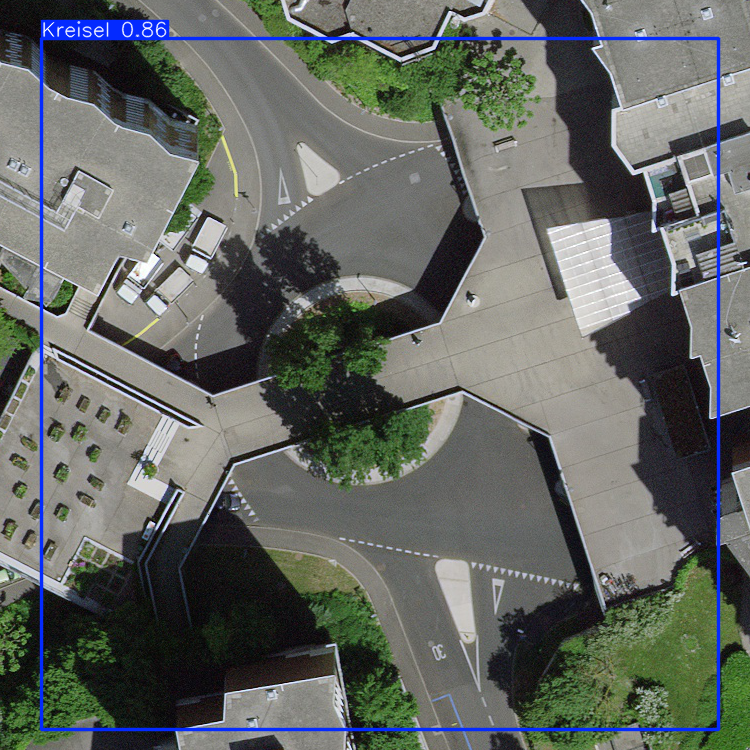

In [9]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# Modell laden (Pfad zu deiner best.pt)
model = YOLO('/content/drive/MyDrive/AI-Projekt/runs/detect/kreisel_modell_v1/weights/best.pt')

# Vorhersage auf einem Bild machen (ersetze den Pfad mit einem Testbild)
results = model.predict(source='/content/drive/MyDrive/Colab Notebooks/Bsc/SwissImageTiles_Kreisel_0.1m/kreisel_99_2023_41.5m.tif', conf=0.5)

# Ergebnis anzeigen
for r in results:
    im_array = r.plot()  # Bounding Box auf das Bild zeichnen
    cv2_imshow(im_array)

Trainings-Statistiken (Loss & Genauigkeit):


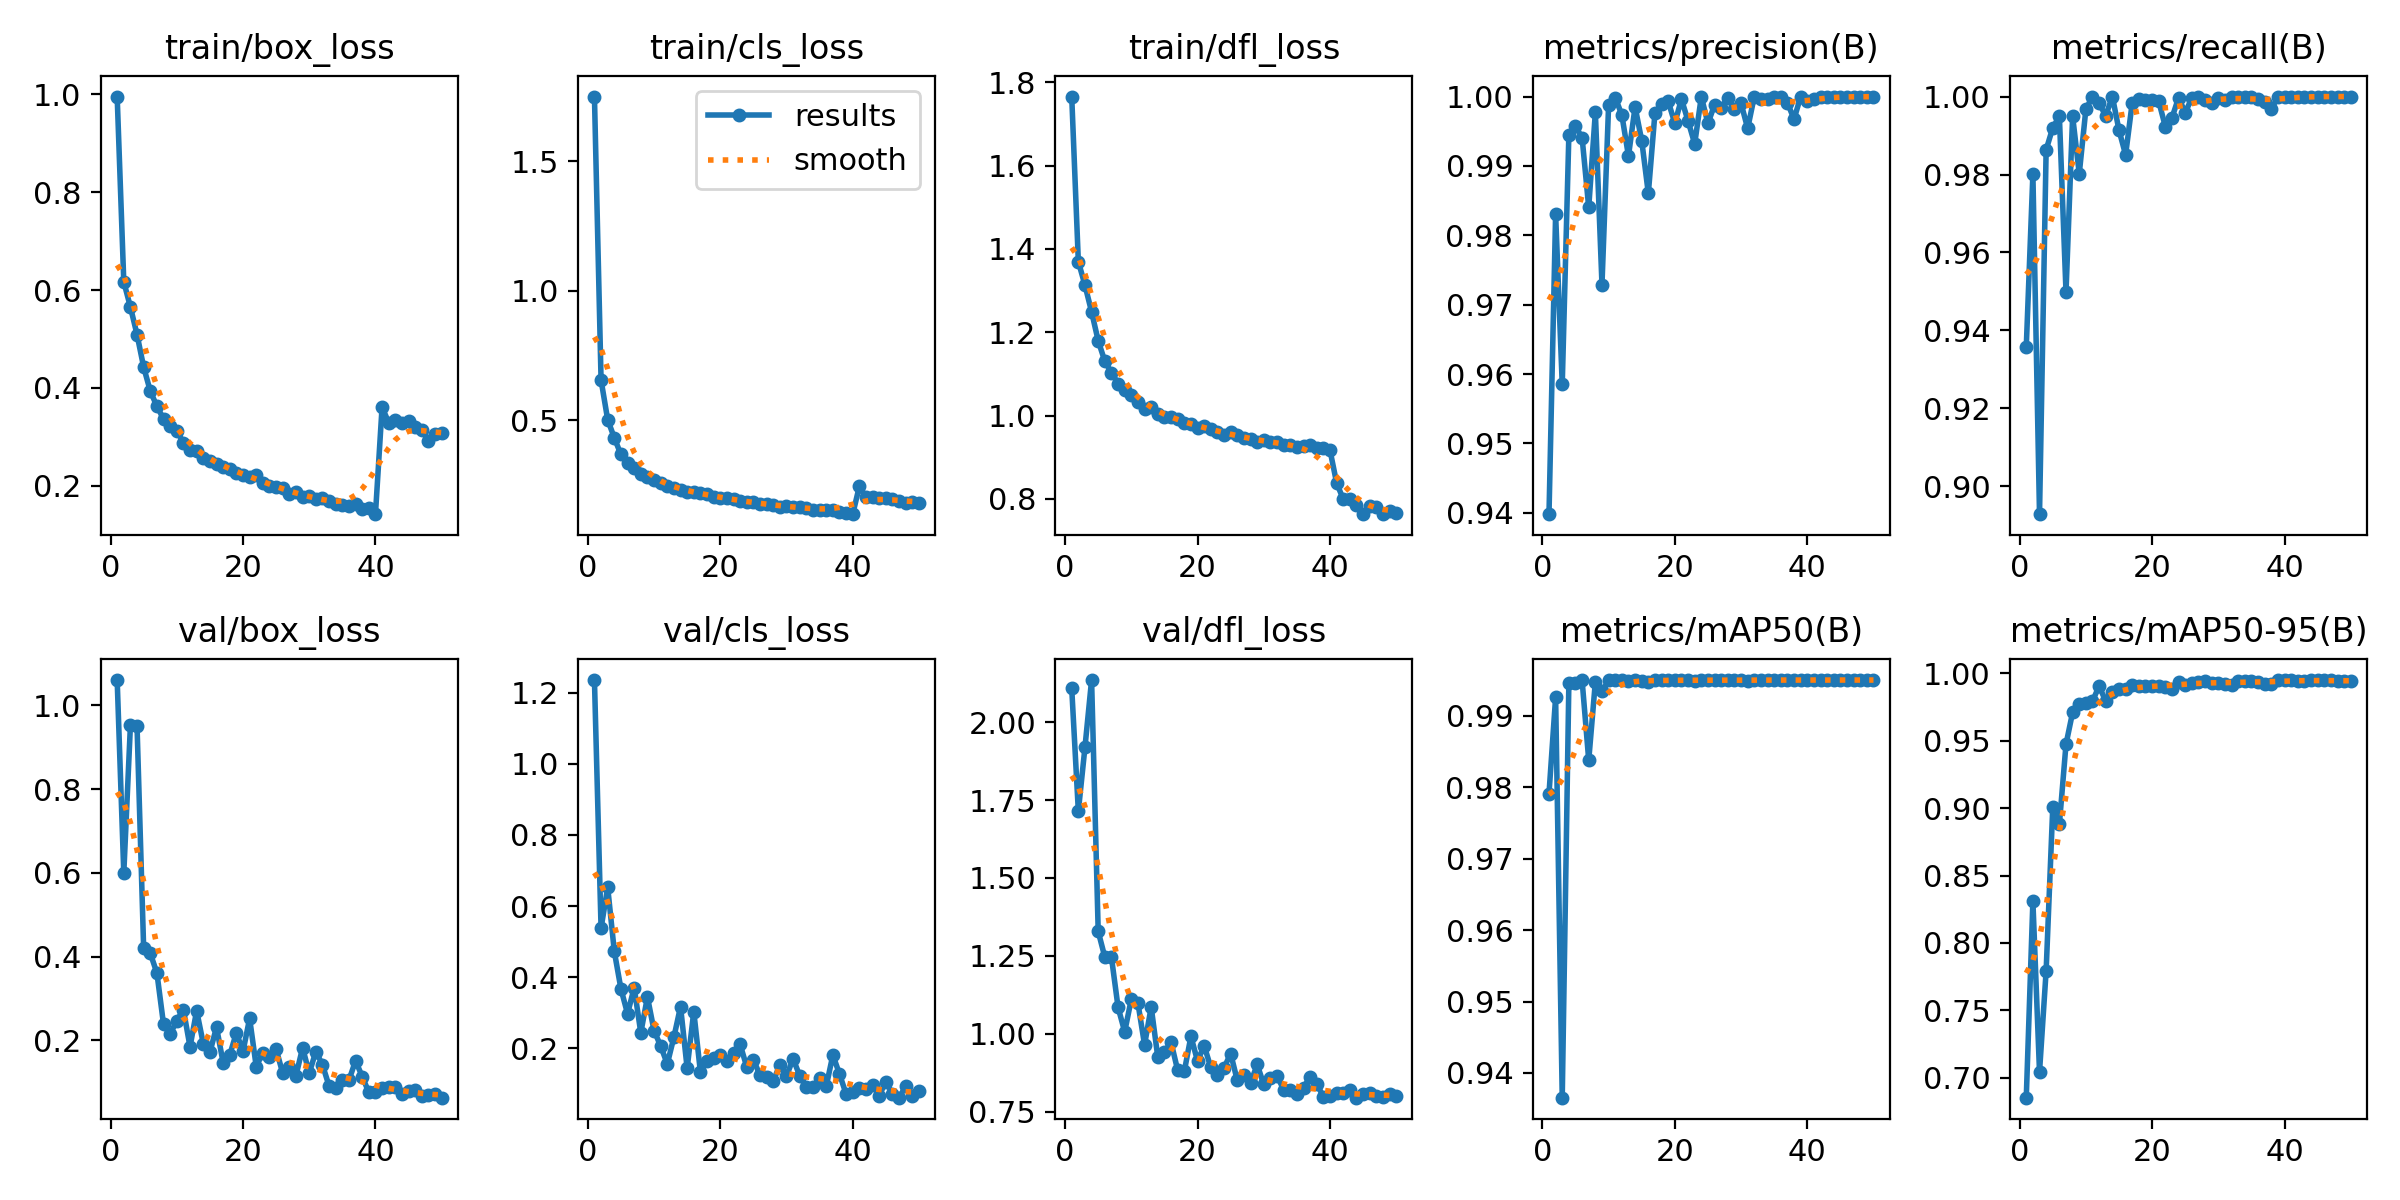

In [12]:
from IPython.display import Image, display
import os

# KORRIGIERTER PFAD (Pointet auf dein Google Drive)
latest_run = "/content/drive/MyDrive/AI-Projekt/runs/detect/kreisel_modell_v1/"

# Pfad zur Datei
results_path = os.path.join(latest_run, "results.png")

# 1. Lernkurven anzeigen
if os.path.exists(results_path):
    print("Trainings-Statistiken (Loss & Genauigkeit):")
    display(Image(filename=results_path, width=800))
else:
    print(f"Datei nicht gefunden unter: {results_path}")
    print("Bitte prüfe, ob dein Google Drive gemountet ist.")

In [10]:
from IPython.display import Image, display
import os

# Pfad zum neuesten Trainings-Lauf (YOLO nummeriert diese: v1, v2, etc.)
latest_run = "/content/runs/detect/kreisel_modell_v1/"

# 1. Lernkurven anzeigen
print("Trainings-Statistiken (Loss & Genauigkeit):")
display(Image(filename=f"{latest_run}results.png", width=800))

Trainings-Statistiken (Loss & Genauigkeit):


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/kreisel_modell_v1/results.png'

Confusion Matrix (Was verwechselt das Modell?):


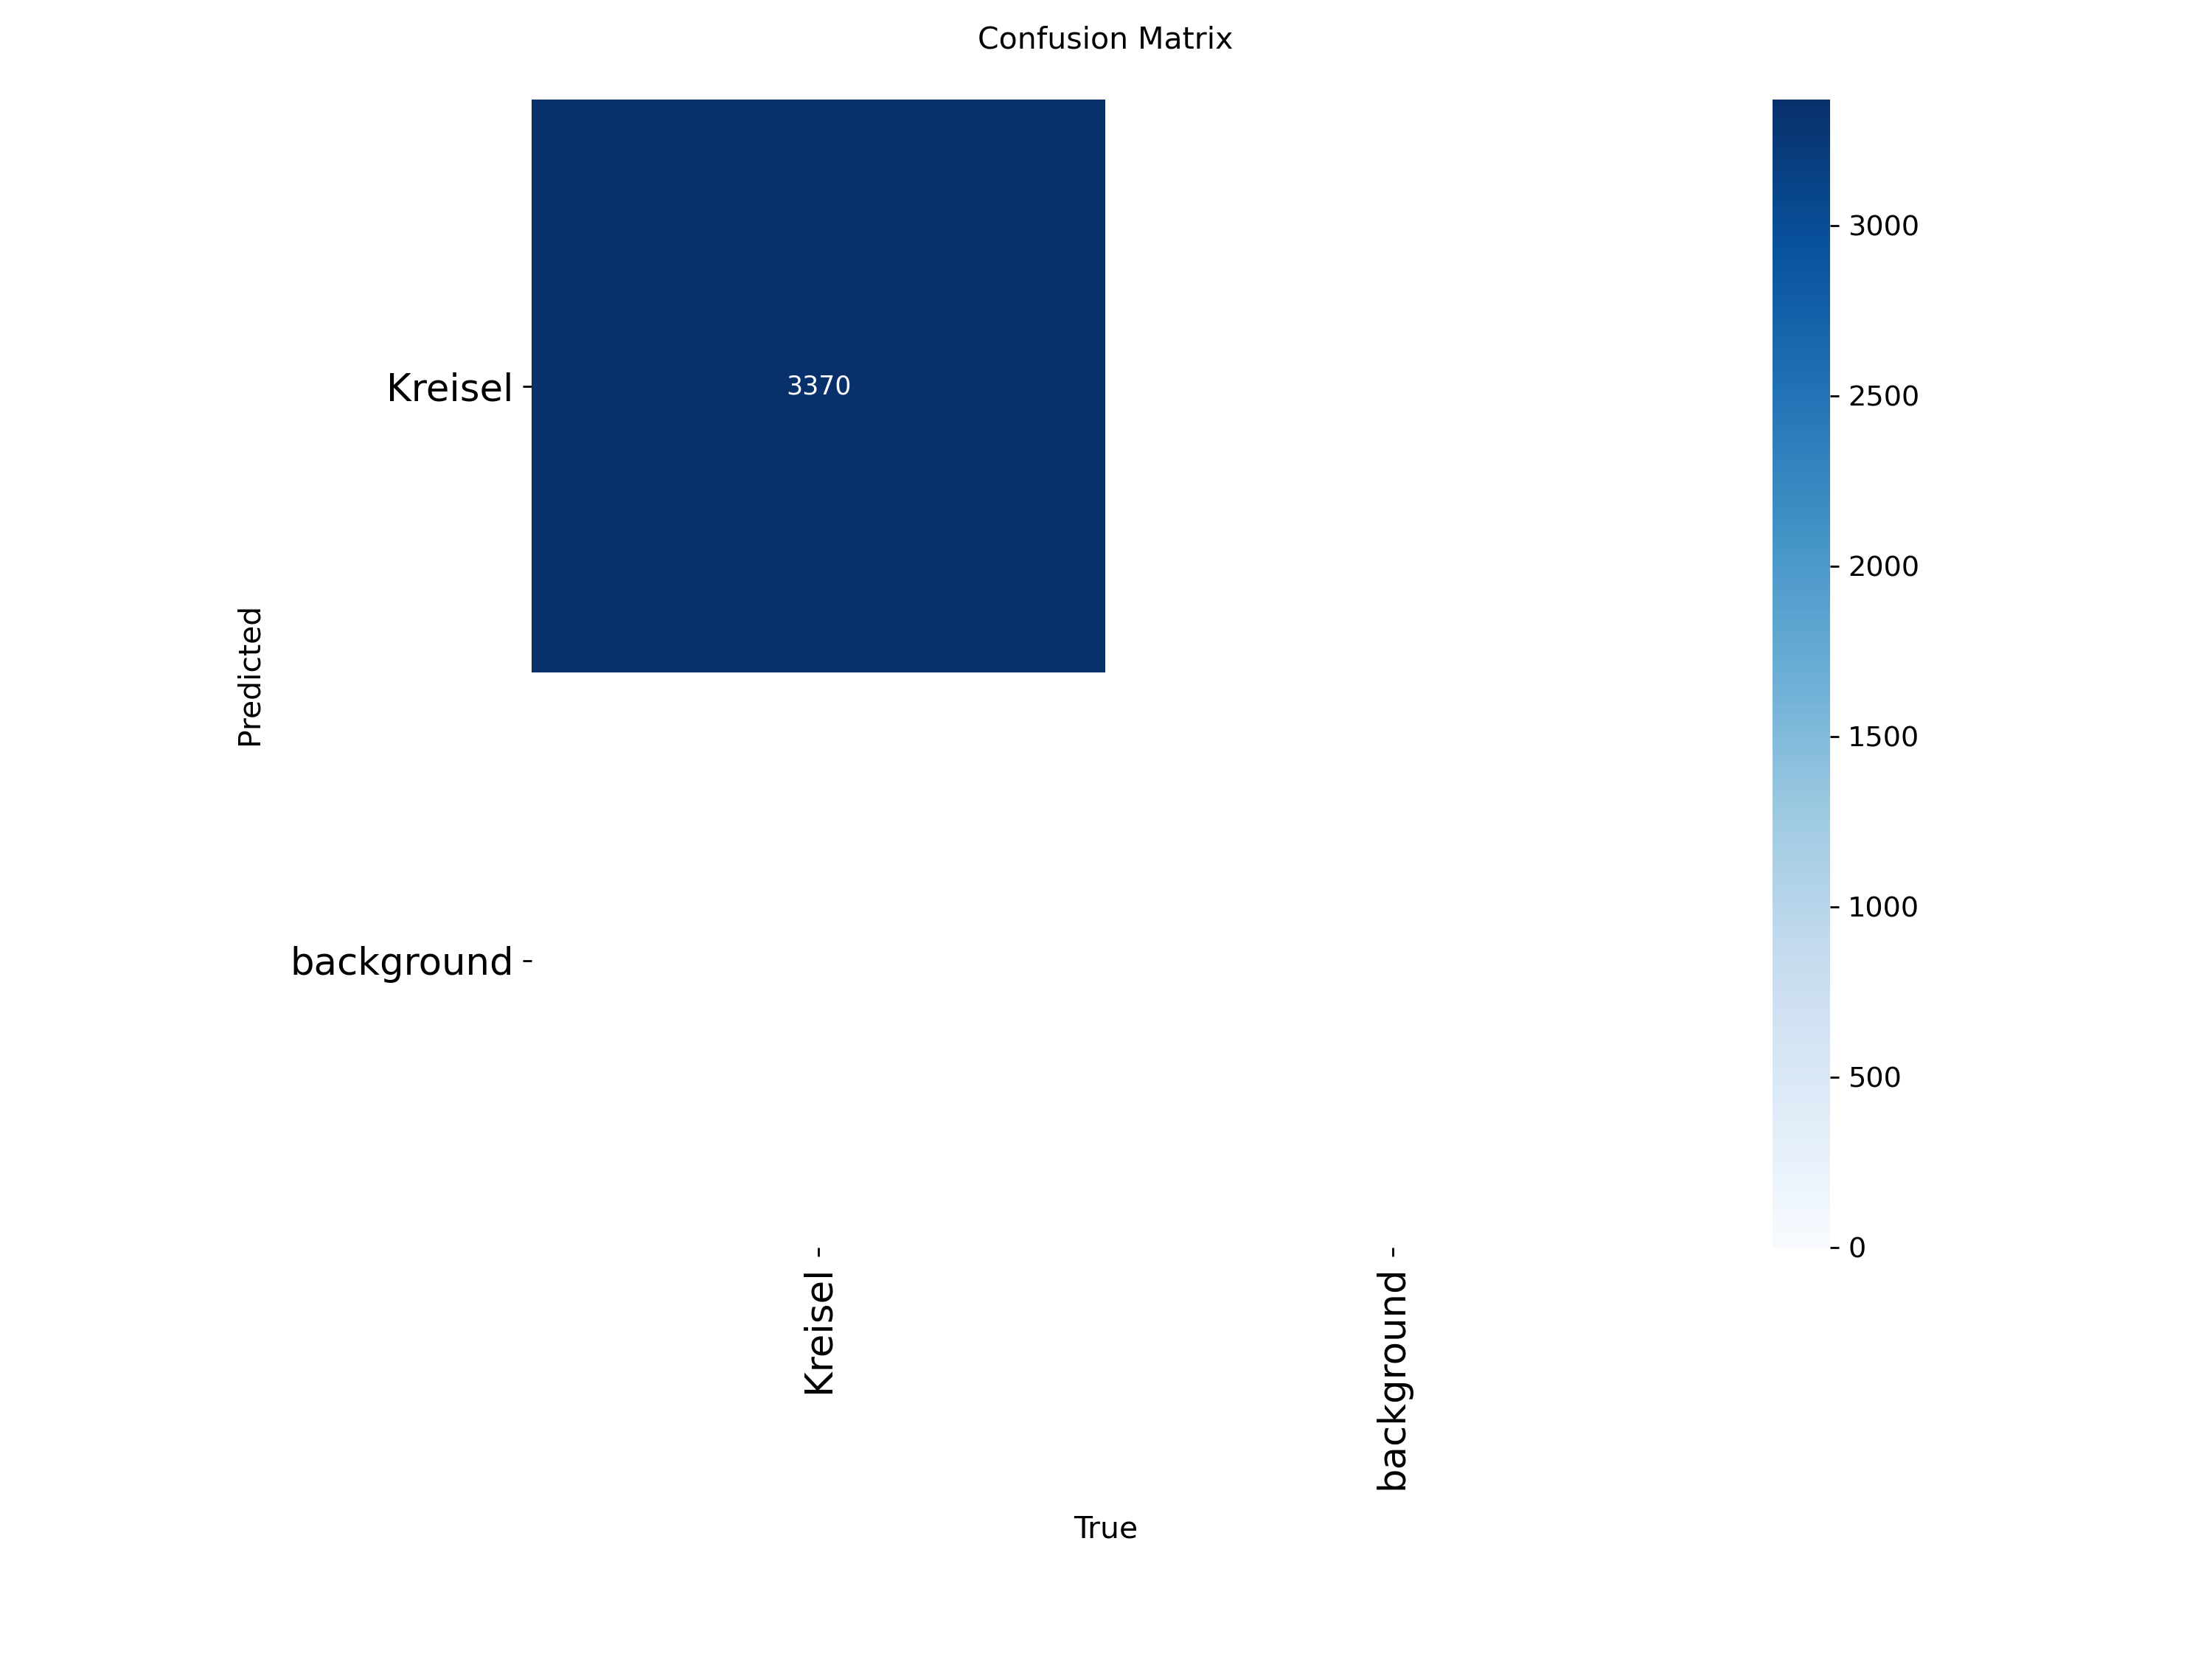

In [13]:
print("Confusion Matrix (Was verwechselt das Modell?):")
display(Image(filename=f"{latest_run}confusion_matrix.png", width=600))

Beispiel-Vorhersagen des Modells:


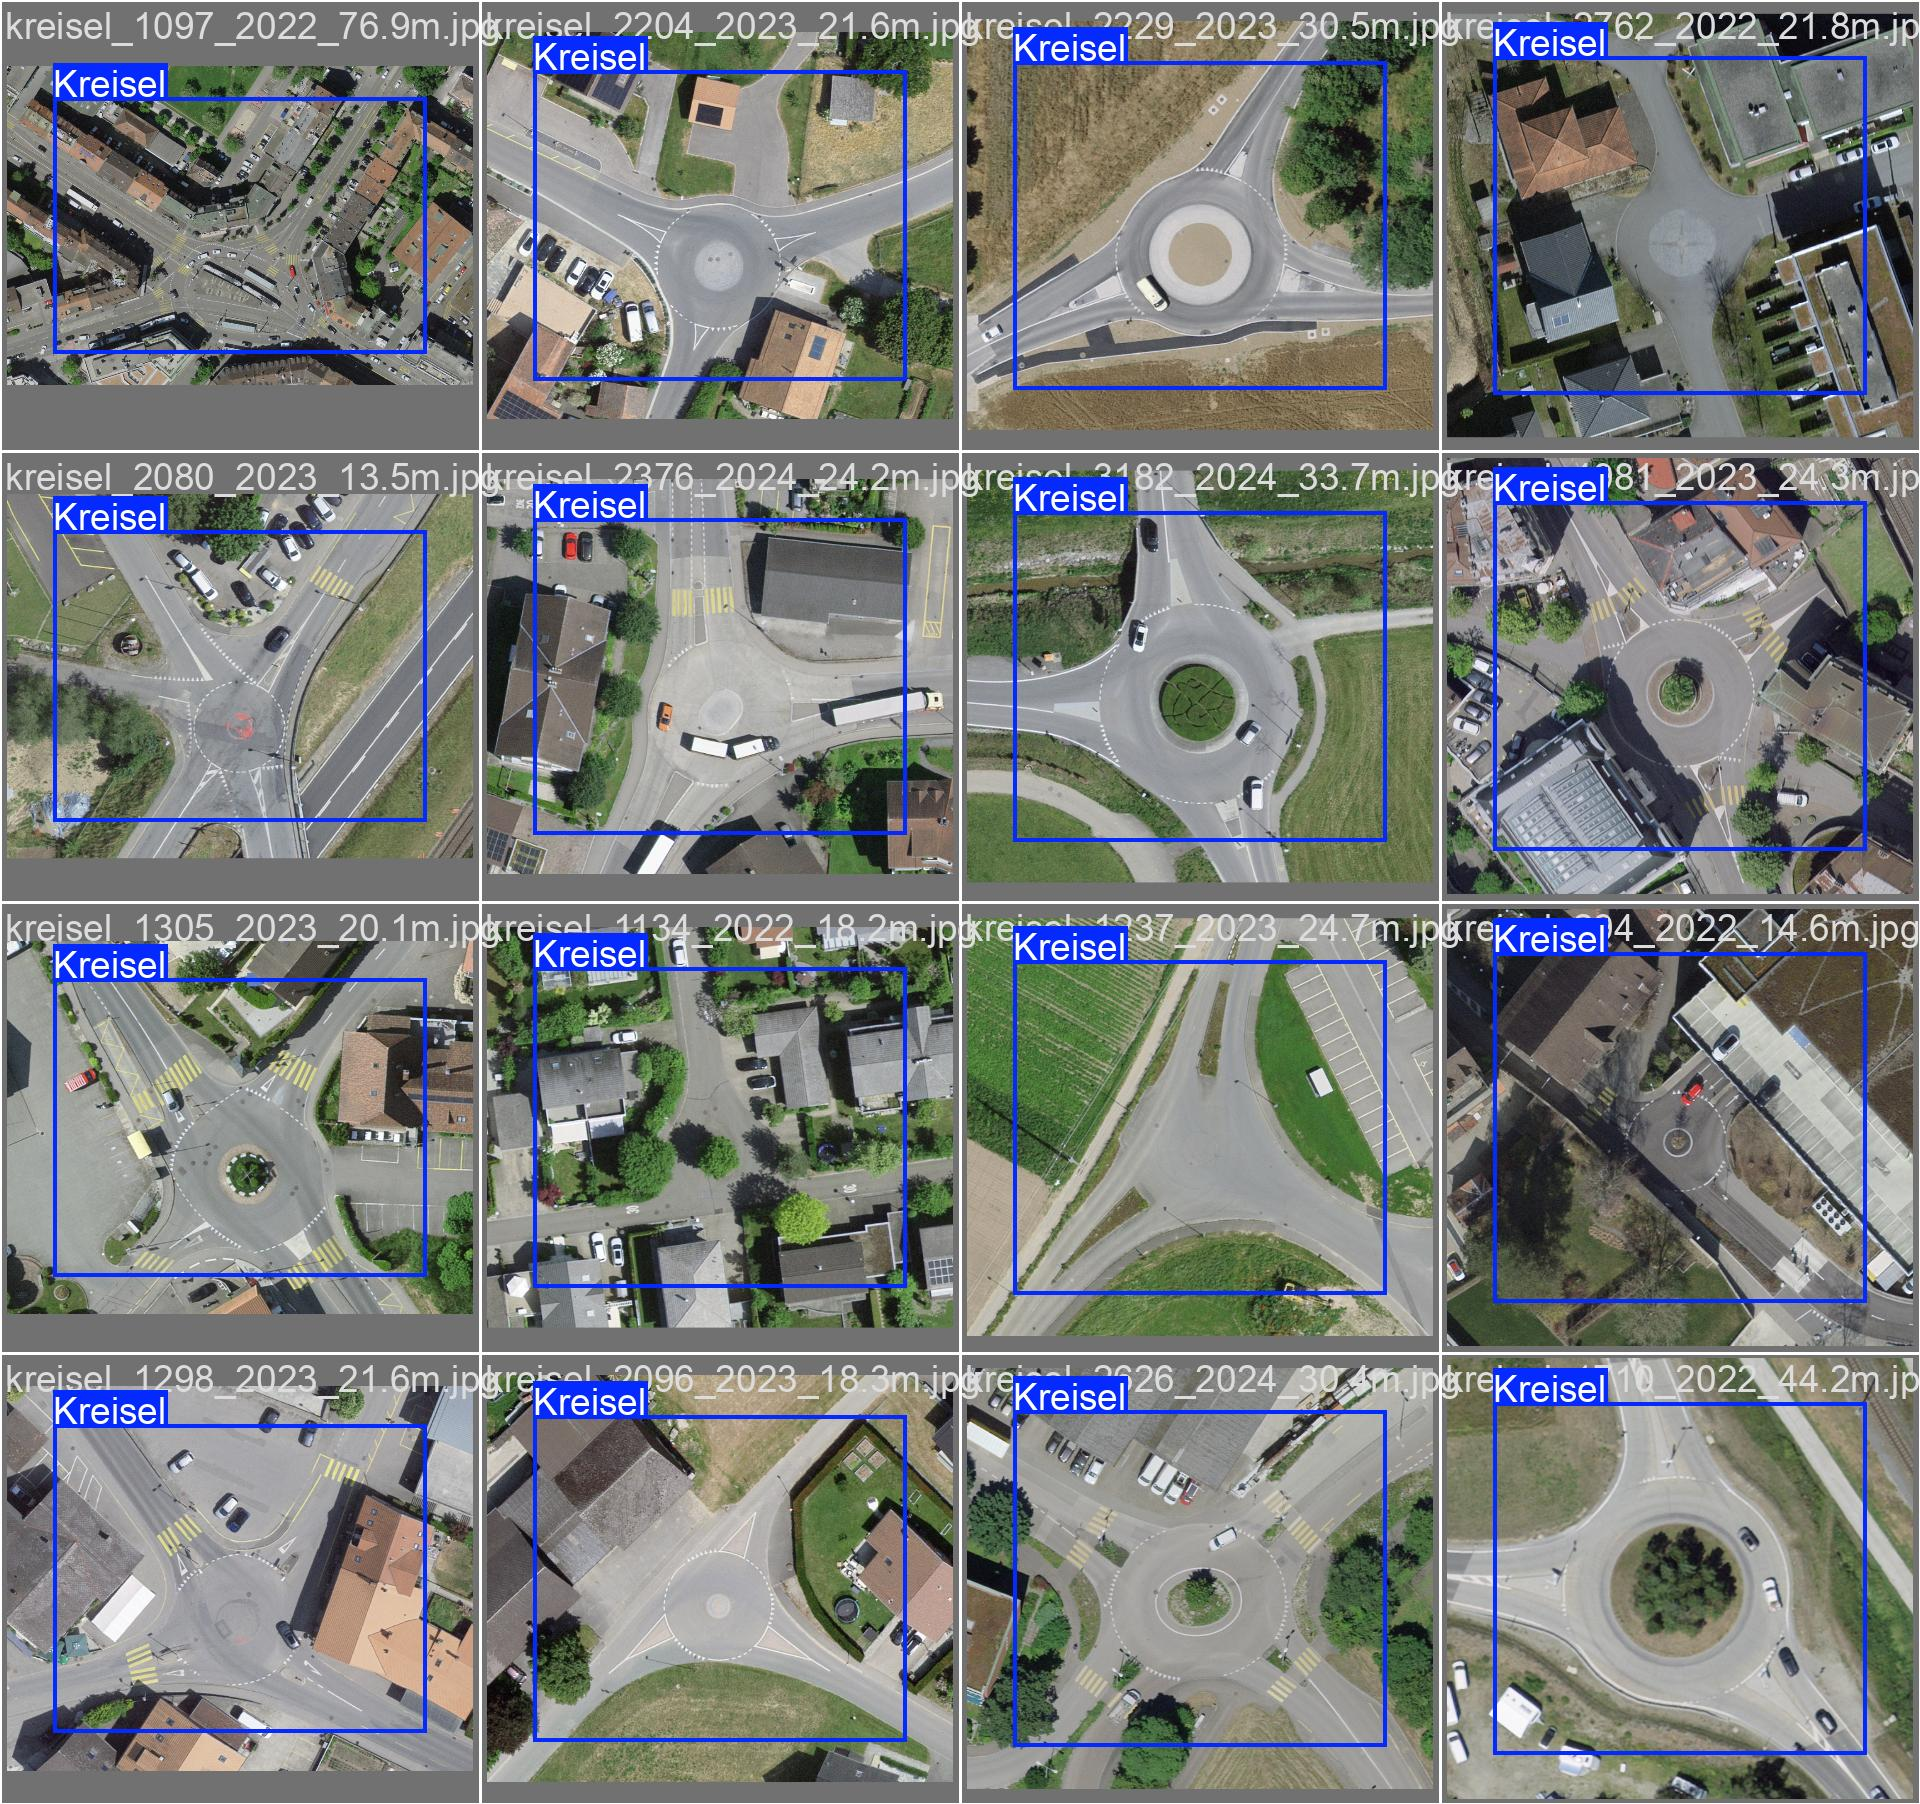

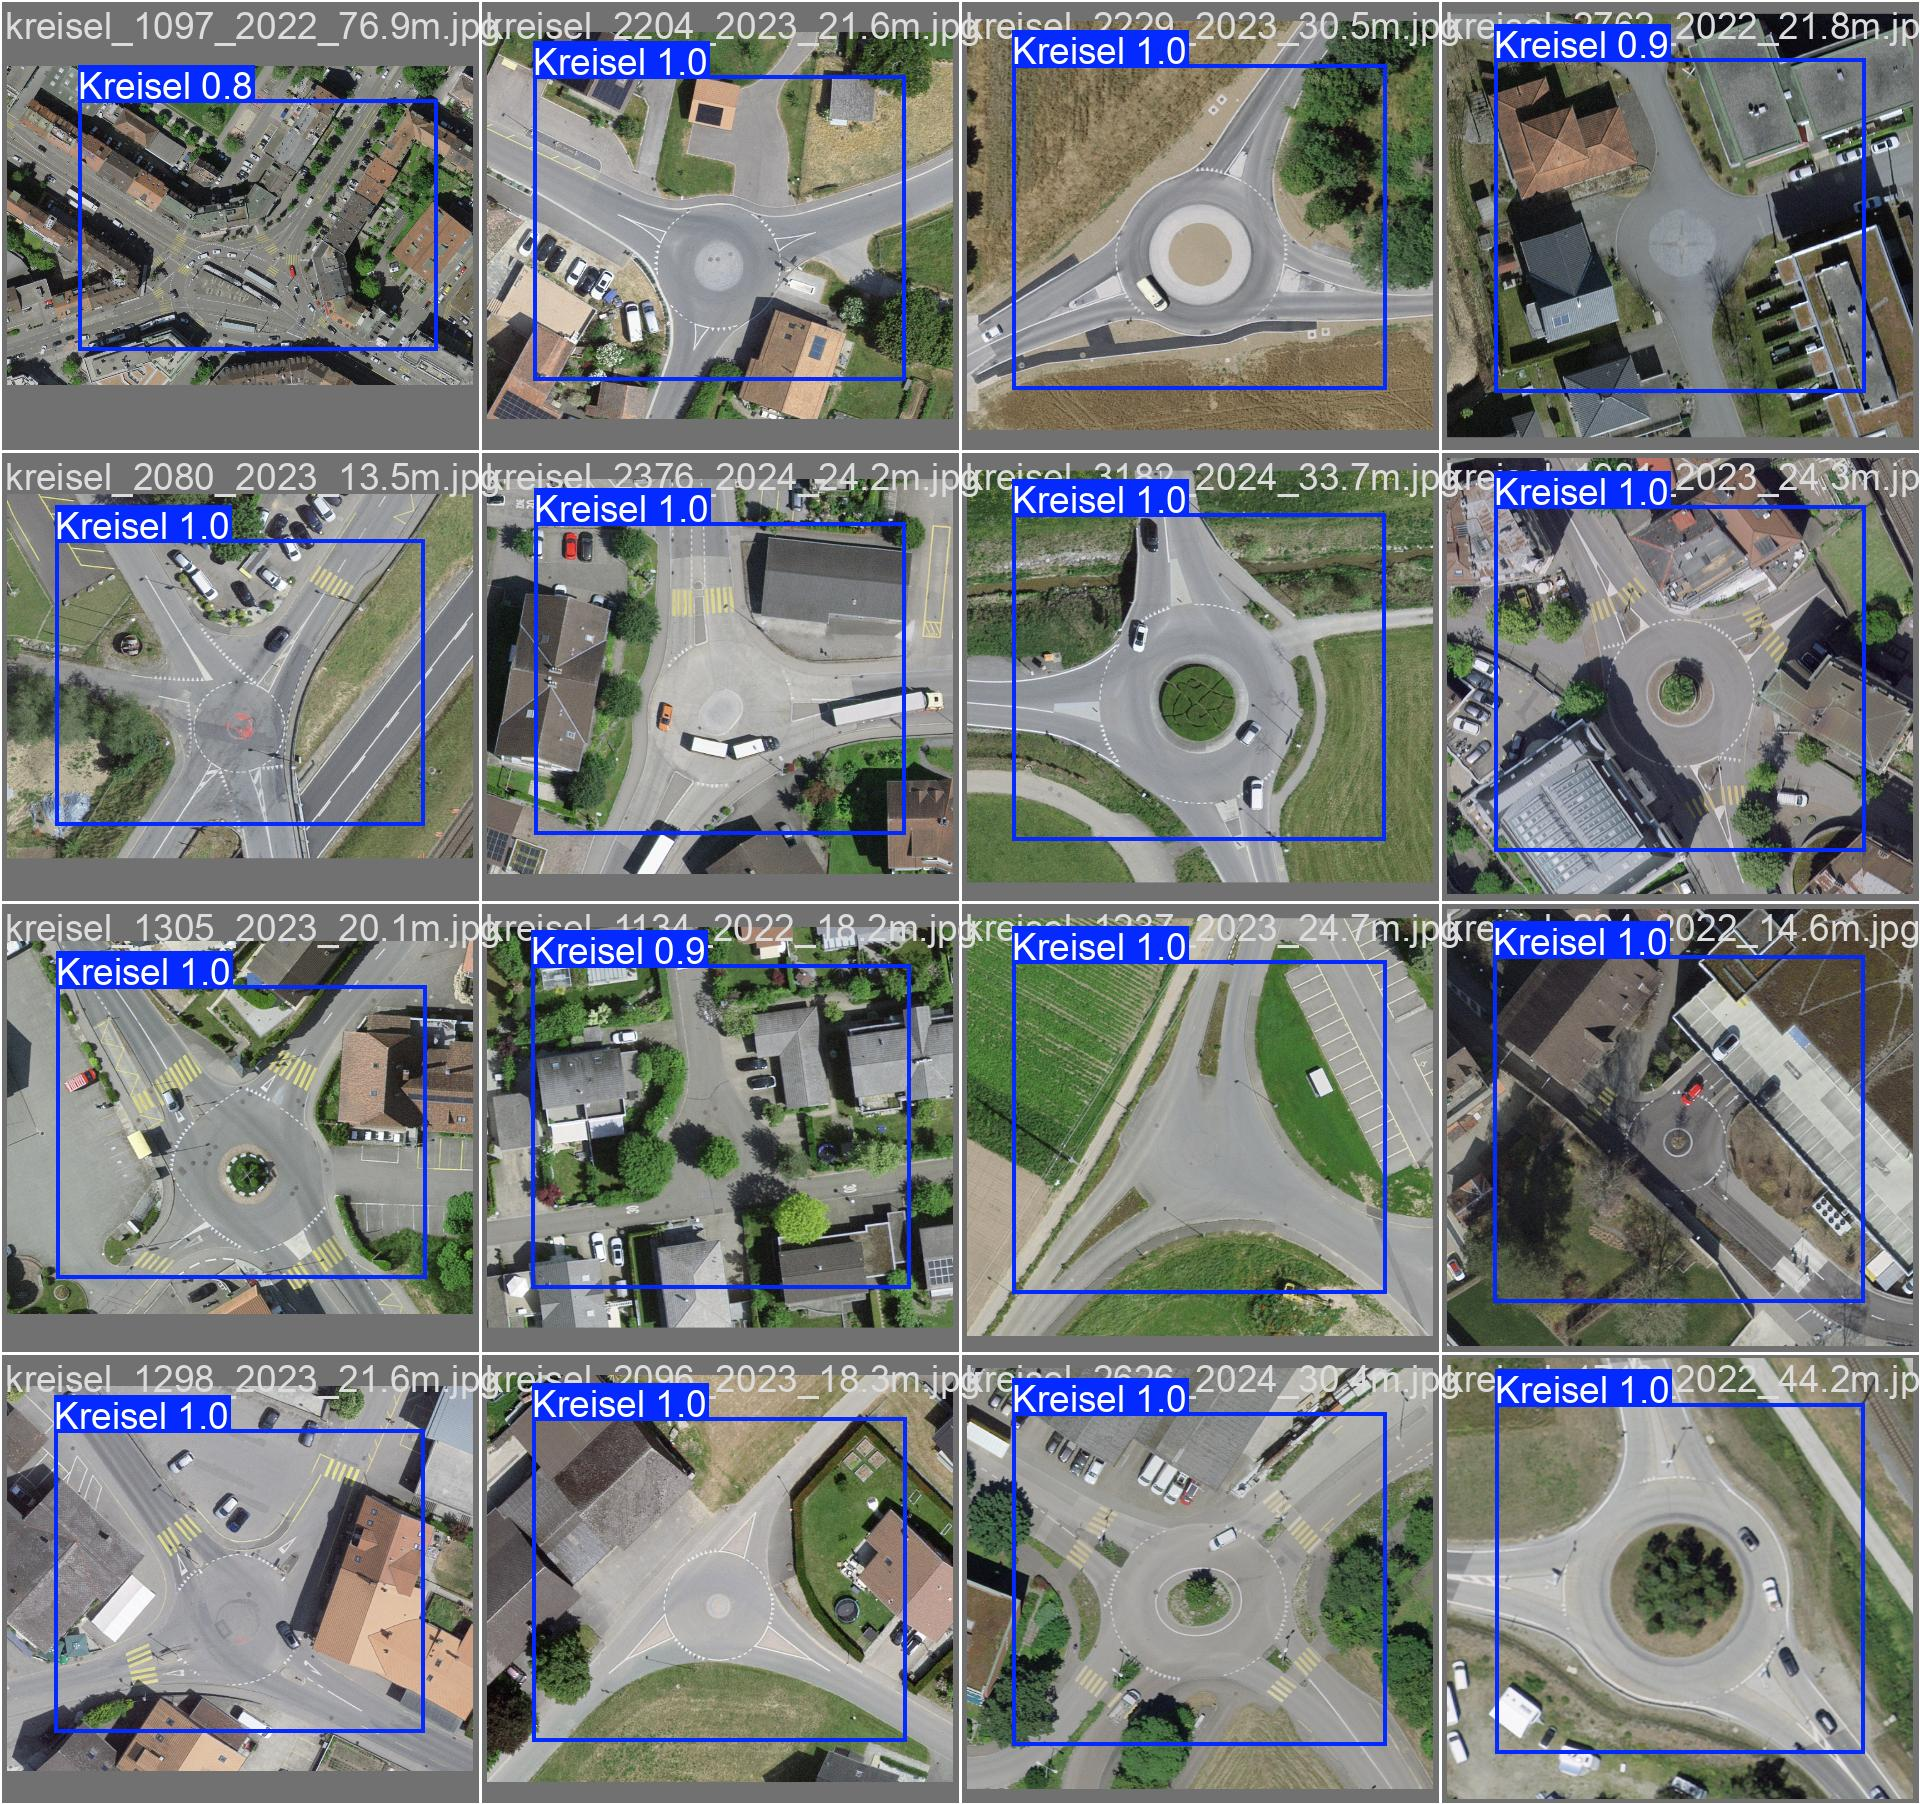

In [14]:
# Zeige die ersten Vorhersagen auf den Testbildern
print("Beispiel-Vorhersagen des Modells:")
display(Image(filename=f"{latest_run}val_batch0_labels.jpg", width=800)) # Die echten Labels
display(Image(filename=f"{latest_run}val_batch0_pred.jpg", width=800))   # Die Vorhersagen der KI

In [16]:
!pip install -U sahi ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88


In [ ]:
import os
import pandas as pd
import re
import requests
import cv2
import numpy as np
from tqdm import tqdm
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from ultralytics import YOLO

# --- KONFIGURATION ---
csv_path = "/content/drive/MyDrive/Colab Notebooks/Bsc/ch.swisstopo.swissimage-dop10-SYwTLgqD.csv"
model_weights = "/content/drive/MyDrive/AI-Projekt/runs/detect/kreisel_modell_v1/weights/best.pt"
image_dir = "/content/drive/MyDrive/Colab Notebooks/Bsc/SwissImageTiles_40k/"
output_csv = "/content/drive/MyDrive/Colab Notebooks/Bsc/inventar_kreisel_schweiz_turbo.csv"

# 1. MODELLE LADEN
native_model = YOLO(model_weights)
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=model_weights,
    confidence_threshold=0.35,
    device="cuda",
)

# 2. HILFSFUNKTIONEN
def pixel_to_lv95(tile_name, px_x, px_y):
    match = re.search(r'_(\d+)-(\d+)_', tile_name)
    if match:
        e_min = int(match.group(1)) * 1000
        n_max = (int(match.group(2)) * 1000) + 1000
        return e_min + (px_x * 0.1), n_max - (px_y * 0.1)
    return None, None

# 3. CHECKPOINT LADEN (Falls Datei existiert)
if os.path.exists(output_csv):
    df_existing = pd.read_csv(output_csv)
    processed_tiles = set(df_existing['tile_name'].unique())
    results_list = df_existing.to_dict('records')
    print(f"📌 Checkpoint gefunden: {len(processed_tiles)} Kacheln bereits verarbeitet.")
else:
    processed_tiles = set()
    results_list = []

# 4. VERARBEITUNG
df_urls = pd.read_csv(csv_path, header=None, names=["url"])

print("🚀 Starte Turbo-Inferenz...")

for url in tqdm(df_urls["url"]):
    filename = url.split("/")[-1]

    # Überspringen, wenn bereits verarbeitet
    if filename in processed_tiles:
        continue

    img_path = os.path.join(image_dir, filename)

    # Download falls nötig
    if not os.path.exists(img_path):
        try:
            r = requests.get(url, timeout=15)
            with open(img_path, "wb") as f: f.write(r.content)
        except: continue

    try:
        # STUFE 1: SCHNELLER SCAN (Ganzes Bild)
        img = cv2.imread(img_path)
        if img is None: continue

        # Auf 1280px herunterskalieren für den Vor-Check
        quick_results = native_model.predict(img, conf=0.15, imgsz=1280, verbose=False)

        # Wenn nichts gefunden wurde -> Kachel abhaken
        if len(quick_results[0].boxes) == 0:
            processed_tiles.add(filename)
            continue

        # STUFE 2: SAHI PRÄZISION (Slicing)
        # Parameter 'perform_standard_predict' entfernt, da fehlerhaft
        result = get_sliced_prediction(
            img,
            detection_model,
            slice_height=1024,
            slice_width=1024,
            overlap_height_ratio=0.15,
            overlap_width_ratio=0.15,
            verbose=0
        )

        for pred in result.object_prediction_list:
            bbox = pred.bbox.to_xyxy()
            cx, cy = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
            east, north = pixel_to_lv95(filename, cx, cy)
            results_list.append({
                "tile_name": filename,
                "confidence": pred.score.value,
                "LV95_E": east, "LV95_N": north
            })

        # Kachel als erledigt markieren und CSV zwischenspeichern alle 10 Kacheln
        processed_tiles.add(filename)
        if len(processed_tiles) % 10 == 0:
            pd.DataFrame(results_list).to_csv(output_csv, index=False)

    except Exception as e:
        print(f"Fehler bei {filename}: {e}")

# Finales Speichern
df_final = pd.DataFrame(results_list)
if not df_final.empty:
    df_final = df_final.sort_values('confidence', ascending=False).drop_duplicates(subset=['LV95_E', 'LV95_N'])
    df_final.to_csv(output_csv, index=False)

print(f"\n✅ Fertig! Ergebnisse in {output_csv}")